# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw2_123456789_987654321.ipynb` if you submitted in pairs and `hw2_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
1. Your code must run without errors. Make sure your `numpy` version is at least 1.15.4 and that you are using at least python 3.6. Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

# I have read and understood the instructions: *** 200705754 *** ***032547275***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x7f202cbc2668>, <__main__.Node at 0x7f202cbc22e8>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')
len(data)

8124

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
def remove_missing_values(data : pd.DataFrame): 
    '''find columns with missing values and remove them from the data'''
    data = data.dropna(axis='rows')
    return data

In [6]:
data = remove_missing_values(data)

We will split the dataset to `Training` and `Testing` datasets.

In [7]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [8]:
y.shape #number of samples

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [9]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    _ , counts = np.unique(data[:,-1], return_counts = True)
    n = len(data) # number of samples 
    probs = counts/n    
    gini = 1- np.sum(probs**2)
    return gini

In [10]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    _ , counts = np.unique(data[:,-1], return_counts = True)
    n = len(data) # number of samples 
    probs = counts/ n    
    entropy = -np.sum(probs*np.log2(probs))
    return entropy

In [11]:
##### Your Tests Here #####
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [12]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    
    # goodness of split
    impurity_data = impurity_func(data) # calculated impurity of the data
    unique_values = np.unique(data[:,feature]) # list of all unique values in feature
    impurities_sum = 0
    num_of_samples = len(data)
    for value in unique_values: # for every uniquie value we calculate impurity and compue weighted average
        n = len(data[data[:,feature]==value])
        weight =  n/num_of_samples
        impurities_sum += weight * impurity_func(data[data[:,feature] == value])

    goodness = impurity_data - impurities_sum # impurity gain
    information_gain = goodness
    
    #gain ratio
    if gain_ratio: #if True we normalize by split information
        values, counts = np.unique(data[:, feature], return_counts = True)
        probs = counts/num_of_samples
        split_information = -np.sum(probs*np.log2(probs))
        goodness = information_gain / split_information

    return goodness    

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

We construct the tree starting from the root by recursion: 
<br>for each node we call the function buid_subtree that calculates imputirty for every feature and chooses the best one in terms of impurity gain. Then we call build subtree agin for each one of the child nodes and continue building the tree according to the impurity criterion. 
<br>We stop in one of the following conditions: 
1. Pure node (only one class) 
2. max depth reached. 
3. node contains min_samples or less samples.   

In [13]:

class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, feature_value, feature, parent_feature, pred=None):
        self.feature = feature # column index of criteria being tested
        self.feature_value = feature_value #indicates the feature value according to which samples were splitted from the parent node
        self.parent_feature = parent_feature #the feature index that was used for splitting from the parent node(level above).
        self.children = []
        self.is_leaf = False #we want to know if the node is a leaf (reached the end of the tree)
        self.pred = pred
        self.class_counts=None

    def add_child(self, node):
        self.children.append(node)

    def get_is_leaf(self):
        return self.is_leaf
    
    def set_is_leaf(self, value):
        self.is_leaf = value

In [14]:
def build_subtree(data, impurity=calc_entropy, gain_ratio=False, max_depth=1000, parent_feature=None, feature_value=None, min_samples_split=1):
    
    # find best feature according to goodness of split criterion
    best_feature = -1
    goodness_value = -1
    for feature_index, feature_column in enumerate(data[:,:-1].T):
        gain = goodness_of_split(data, feature_index, impurity, gain_ratio)
        if gain > goodness_value:
            goodness_value = gain
            best_feature = feature_index

    #check if we have reached one of the stop conditions
    if goodness_value == 0 or not max_depth or len(data)<=min_samples_split:
        # no gain by splitting anymore or too deep in recursion
        node = DecisionNode(feature_value, None, parent_feature)
        node.set_is_leaf(True)
        labels, counts = np.unique(data[:, -1], return_counts=True)
        node.class_counts = dict(zip(labels, counts))
        if len(counts)==1:
            #only one clss
            node.pred=labels[0]
        else:
            #majority vote
            node.pred = labels[np.argmax(counts)]
    else:
        node = DecisionNode(feature_value, best_feature, parent_feature)
        feature_values = np.unique(data[:, best_feature])
        for feature_value in feature_values:
            data_per_feature_val = data[data[:,best_feature] == feature_value]
            labels, counts = np.unique(data_per_feature_val[:, -1], return_counts=True)
            if len(counts) == 1:
                # stop if the subset is pure
                child_node = DecisionNode(feature_value, None, parent_feature)
                child_node.set_is_leaf(True)
                #return the class
                child_node.pred = labels[0]
                child_node.class_counts = dict(zip(labels, counts))
            else:
                #if not pure continue building the tree. Reduced max_depth for the subtree (because we added one leve)
                child_node = build_subtree(data=data_per_feature_val, impurity=impurity, gain_ratio=gain_ratio, 
                                           max_depth=max_depth-1, 
                                           feature_value=feature_value, parent_feature=best_feature, min_samples_split=min_samples_split)
            node.add_child(child_node)

    return node

In [15]:
def build_tree(data, impurity, gain_ratio=False, min_samples_split=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """

    root = None

    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################

    parent_feature = None
    feature_value = None
    root = build_subtree(data=data, impurity=impurity, max_depth=max_depth, gain_ratio=gain_ratio, parent_feature=parent_feature,
                         feature_value=feature_value, min_samples_split=min_samples_split)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return root

In [16]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

We traverse the tree recursively from the root and in each level we choose the child with the same feature value as the instance till we get to the leaf. Then we reurn the value (determined by majority vote if not pure). 

In [17]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    
    if node.get_is_leaf():
        return node.pred
    else:
        for child in node.children:
            if instance[node.feature] == child.feature_value:
                node.pred = predict(child, instance)
                break
                
    return node.pred

In [18]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    TP_counter = 0
    
    for i in range(dataset.shape[0]):
        if predict(node, dataset[i,:]) == dataset[i,-1]:
            TP_counter +=1
    
    accuracy = TP_counter / dataset.shape[0]
    
    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [19]:
trees_results={}
trees_results["tree_gini"] = {"training": calc_accuracy(tree_gini, X_train), "test": calc_accuracy(tree_gini, X_test)}
trees_results["tree_entropy"] = {"training": calc_accuracy(tree_entropy, X_train), "test": calc_accuracy(tree_entropy, X_test)} 
trees_results["tree_entropy_gain_ratio"] = {"training": calc_accuracy(tree_entropy_gain_ratio, X_train), "test": calc_accuracy(tree_entropy_gain_ratio, X_test)} 

best_tree_name=None
best_test_accuracy=0

for tree_name, tree_results in trees_results.items():
    print(f"################# {tree_name} model evaluation ###################")
    for set_name, set_accuracy in tree_results.items():
        print(f"{set_name} accuracy: {set_accuracy*100:.2f}%")
        if set_name=="test" and set_accuracy>best_test_accuracy:
            best_tree_name=tree_name
            best_test_accuracy=set_accuracy

################# tree_gini model evaluation ###################
training accuracy: 99.25%
test accuracy: 77.60%
################# tree_entropy model evaluation ###################
training accuracy: 99.41%
test accuracy: 77.79%
################# tree_entropy_gain_ratio model evaluation ###################
training accuracy: 99.64%
test accuracy: 78.43%


In [20]:
print(f"tree with best test accuracy is {best_tree_name}")

tree with best test accuracy is tree_entropy_gain_ratio


In [21]:
best_tree=tree_entropy_gain_ratio #We will use this tree for further calculations in next sections

## Depth pruning

(15 points)

Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the max_depth. Mark the best result on the graph with red circle.

In [22]:
def prune_trees_depth(max_depths, train_data, test_data, impurity=calc_entropy, gain_ratio=True):
    '''generate pruned trees according to max_depths vals and return their accuracies'''
    trees_training_accuracies = []
    trees_testing_accuracies = []
    pruned_trees = []
    for depth in max_depths:
        #we use the tree with best entroy from previous section
        pruned_trees.append(build_tree(data=train_data, impurity=calc_entropy, gain_ratio=True, max_depth=depth))
    for tree in pruned_trees:
        trees_training_accuracies.append(calc_accuracy(tree, train_data))
        trees_testing_accuracies.append(calc_accuracy(tree, test_data))
    return trees_training_accuracies, trees_testing_accuracies

def plot_pruned_trees_accuracies(hyper_parameter_name, hyper_parameter_vals, trees_training_accuracies, trees_testing_accuracies):
    best_index = trees_testing_accuracies.index(max(trees_testing_accuracies))
    plt.scatter(hyper_parameter_vals,trees_training_accuracies, label='Training')
    plt.scatter(hyper_parameter_vals,trees_testing_accuracies,  label='Testing')
    plt.plot(hyper_parameter_vals,trees_training_accuracies)
    plt.plot(hyper_parameter_vals,trees_testing_accuracies)
    plt.plot(hyper_parameter_vals[best_index], trees_testing_accuracies[best_index], color='red', marker = 'o', ms = 10, label='best result')
    plt.title(f'Training and testing accuracy as a function of the {hyper_parameter_name}', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel(f'{hyper_parameter_name}', fontsize=14)
    plt.legend(loc="upper center", fontsize=14)
    plt.show()


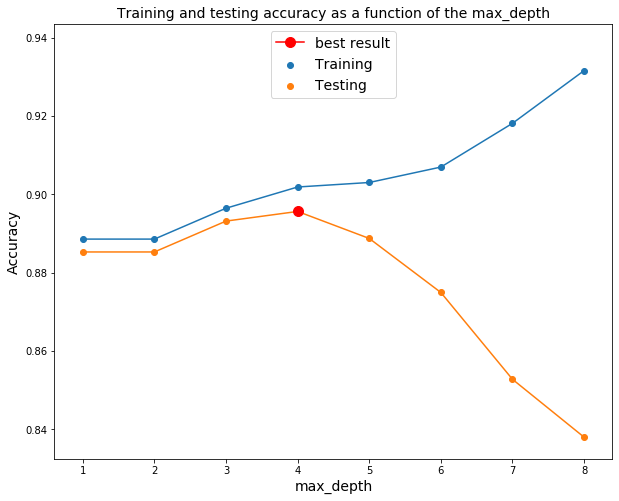

In [23]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8]

trees_training_accuracies, trees_testing_accuracies = prune_trees_depth(max_depths, X_train, X_test,)
plot_pruned_trees_accuracies('max_depth', max_depths, trees_training_accuracies, trees_testing_accuracies)

In [24]:
best_index = trees_testing_accuracies.index(max(trees_testing_accuracies))
best_depth = max_depths[best_index]
print(f"tree with best test accuracy: max_depth_pruning={best_depth}, test accuracy: {trees_testing_accuracies[best_index]*100:.2f}%")

best_tree_depth_prunining = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth=best_depth)

tree with best test accuracy: max_depth_pruning=4, test accuracy: 89.56%


We can notice that for lower max_depths the graph has similar increasing trend for train and test till it reaches the maximum test accuracy for depth=4. Then the graphs start to diverge and the model improves only on the train set while the accuracy decreases on the test set. It shows us that it is sometimes necessary to limit max_depth to avoid overfitting. 


## Min Samples Split

(15 points)

Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, construct a tree and prune it according to the min_samples_split value = don't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the min_samples_split. Mark the best result on the graph with red circle. (make sure that the x-axis ticks represent the values of min_samples_split)

In [25]:
def prune_trees_min_samples(min_samples_split_values, train_data, test_data, impurity=calc_entropy, gain_ratio=True):
    trees_training_accuracies = []
    trees_testing_accuracies = []
    pruned_trees = []
    for min_samples_split in min_samples_split_values:
        pruned_trees.append(build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=min_samples_split))
    for tree in pruned_trees:
        trees_training_accuracies.append(calc_accuracy(tree, X_train))
        trees_testing_accuracies.append(calc_accuracy(tree, X_test))
    return trees_training_accuracies, trees_testing_accuracies

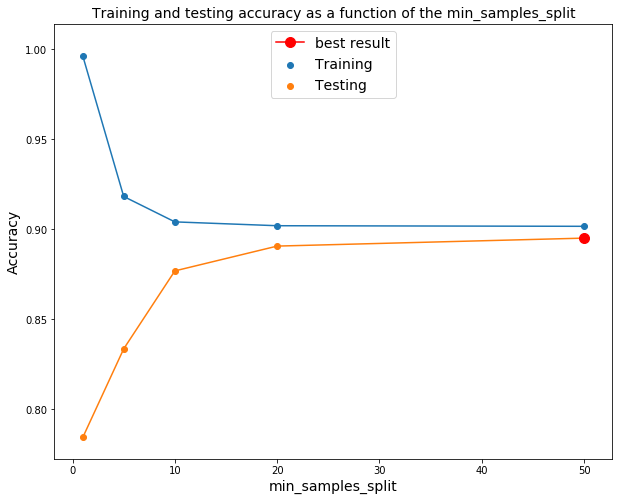

In [26]:
min_samples_split_values = [1, 5, 10, 20, 50]

trees_training_accuracies, trees_testing_accuracies = prune_trees_min_samples(min_samples_split_values, X_train, X_test)
plot_pruned_trees_accuracies('min_samples_split', min_samples_split_values, trees_training_accuracies, trees_testing_accuracies)

In [27]:
best_index = trees_testing_accuracies.index(max(trees_testing_accuracies))
best_min_samples_split = min_samples_split_values[best_index]

print(f"tree with best test accuracy: min_samples_split={best_min_samples_split}, test accuracy: {trees_testing_accuracies[best_index]*100:.2f}%")

tree with best test accuracy: min_samples_split=50, test accuracy: 89.51%


We can notice that for low min_samples_split the accuracy improves on the train set but gets worse on the test set. It shows that setting too low min_samples_split can cause overfitting (splits can be generated only for classifying a few training instances correctly and that creates too much sensitivity to outliers). On the other hand setting it too high might hurt the accuracy since it can limit the abilty to use some of the features that could be important for correct classification. In this case maximum min sample_split = 50 is relatively small compared to the number of instances so using it improves results on the test set.

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [28]:
tree_max_depth = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth=best_depth)
tree_min_samples_split = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=best_min_samples_split)

## Number of Nodes

(5 points)

Complete the function counts_nodes and print the number of nodes in each tree and print the number of nodes of the two trees above

counts_nodes is implemented by recursion strating fromt the root. When visiting a node we add one to the counter and then add the results from calling the count_nodes function on the child nodes. the recursion stops when we get to a leaf (no children).

In [29]:
##########To complete#############################
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    node_counter = 1

    for child_node in node.children:
        node_counter += count_nodes(child_node)

    return node_counter


In [30]:
print(f"number of nodes for tree_max_depth: {count_nodes(tree_max_depth)}")

number of nodes for tree_max_depth: 205


In [31]:
print(f"number of nodes for tree_min_samples_split: {count_nodes(tree_min_samples_split)}")

number of nodes for tree_min_samples_split: 349


## Print the tree

Complete the function `print_tree`. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [32]:
# you can change the function signeture
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    counter=0
    if node.get_is_leaf():
        print(depth *' ' + f'[X{parent_feature}={feature_val}, leaf]: [{node.class_counts}]')
    else:
        if parent_feature=="ROOT":
            print(depth *' ' + f'[{parent_feature}, feature=X{node.feature}]')
        else:
            print(depth *' ' + f'[X{parent_feature}={feature_val}, feature=X{node.feature}]')
        
        for n in node.children:
            print_tree(n, depth=depth + 1, parent_feature=n.parent_feature, feature_val=n.feature_value)

print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [33]:
#printing results for the two pruning methodes including number of nodes  
pruned_trees = []
for min_samples_split in min_samples_split_values:
    tree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, min_samples_split=min_samples_split)
    print(f"min_samples_split = {min_samples_split}, Test accuracy = {calc_accuracy(tree, X_test)*100:.3f}%, nodes={count_nodes(tree)}")

for depth in max_depths:
    tree = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth=depth)
    print(f"max_depth = {depth}, Test accuracy = {calc_accuracy(tree, X_test)*100:.3f}%, nodes={count_nodes(tree)}")

min_samples_split = 1, Test accuracy = 77.006%, nodes=3251
min_samples_split = 5, Test accuracy = 83.161%, nodes=1833
min_samples_split = 10, Test accuracy = 87.691%, nodes=1182
min_samples_split = 20, Test accuracy = 89.069%, nodes=729
min_samples_split = 50, Test accuracy = 89.513%, nodes=349
max_depth = 1, Test accuracy = 88.528%, nodes=10
max_depth = 2, Test accuracy = 88.528%, nodes=32
max_depth = 3, Test accuracy = 89.316%, nodes=83
max_depth = 4, Test accuracy = 89.562%, nodes=205
max_depth = 5, Test accuracy = 88.872%, nodes=422
max_depth = 6, Test accuracy = 87.346%, nodes=765
max_depth = 7, Test accuracy = 85.032%, nodes=1184
max_depth = 8, Test accuracy = 83.407%, nodes=1664


The best pruned tree (highest test accuracy) with less than 50 nodes is the tree with max_depth=2 that has 32 nodes.

In [34]:
best_tree_max_50_nodes = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True, max_depth=2)

print_tree(best_tree_max_50_nodes)

[ROOT, feature=X4]
 [X4=a, feature=X2]
  [X2=n, leaf]: [{'e': 33, 'p': 5}]
  [X2=w, leaf]: [{'e': 107, 'p': 7}]
  [X2=y, leaf]: [{'e': 133, 'p': 19}]
 [X4=c, feature=X6]
  [X6=c, leaf]: [{'e': 7, 'p': 63}]
  [X6=w, leaf]: [{'e': 3, 'p': 74}]
 [X4=f, feature=X10]
  [X10=f, leaf]: [{'e': 14, 'p': 91}]
  [X10=k, leaf]: [{'e': 134, 'p': 1037}]
  [X10=s, leaf]: [{'e': 22, 'p': 310}]
 [X4=l, feature=X1]
  [X1=f, leaf]: [{'e': 19, 'p': 1}]
  [X1=s, leaf]: [{'e': 94, 'p': 16}]
  [X1=y, leaf]: [{'e': 159, 'p': 10}]
 [X4=m, feature=X0]
  [X0=f, leaf]: [{'e': 1, 'p': 8}]
  [X0=k, leaf]: [{'e': 1, 'p': 10}]
  [X4=x, leaf]: [{'p': 7}]
 [X4=n, feature=X7]
  [X7=b, leaf]: [{'e': 2197, 'p': 286}]
  [X7=n, leaf]: [{'e': 135, 'p': 58}]
 [X4=p, feature=X0]
  [X0=f, leaf]: [{'e': 7, 'p': 86}]
  [X0=x, leaf]: [{'e': 1, 'p': 89}]
 [X4=s, feature=X13]
  [X13=p, leaf]: [{'e': 12, 'p': 190}]
  [X13=w, leaf]: [{'e': 26, 'p': 190}]
 [X4=y, feature=X1]
  [X1=s, leaf]: [{'e': 18, 'p': 194}]
  [X1=y, leaf]: [{'e': 